# ДЗ2 Елизаров Константин, MADE-DS-31

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from tictactoe import TicTacToe

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

**Задание:**
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

**Disclaimer:** начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

### Табличное Q-обучение для стратегии крестиков и ноликов для доски 3х3.

In [2]:
env = TicTacToe()

In [3]:
# Класс игрока для запоминания состояния и действия

class Player:
    
    def __init__(self):
        self.state = None
        self.action = None
    
    def update_params(self, state, action):
        self.state = state
        self.action = action

In [4]:
def get_full_and_empty_indices(env, empty_spaces):
    """Получаем индексы свободных и занятых клеток."""
    empty_indices = [env.int_from_action(space) for space in empty_spaces]
    full_indices = list(set(range(env.n_rows * env.n_cols)) - set(empty_indices))
    return empty_indices, full_indices


def update_Q(Q, player, next_state, reward, alpha, gamma):
    """Обновление Q-функции."""
    state, action = player.state, player.action
    Q[state][action] = (1 - alpha) * Q[state][action] + alpha * (reward + gamma * np.max(Q[next_state]))


def q_learning_episode(env, Q, alpha=0.1, eps=0.1, gamma=0.9):
    """Симуляция одного Q-learning эпизода."""
    env.reset()
    players = (Player(), Player())
    state, empty_spaces, turn = env.getState() 
    index = 0
    finish = False
    
    while not finish:
        player = players[index]
        empty_cells, full_cells = get_full_and_empty_indices(env, empty_spaces)
        Q[state][full_cells] = -np.inf
        action = np.argmax(Q[state]) if np.random.random() < (1 - eps) else np.random.choice(empty_cells)
        update_Q(Q, player, state, 0, alpha, gamma)
        player.update_params(state, action)
        (state, empty_spaces, turn), reward, finish, _ = env.step(env.action_from_int(action))
        index = 1 - index
        
    update_Q(Q, players[0], state, reward, alpha, gamma)
    update_Q(Q, players[1], state, -reward, alpha, gamma)
        
    return Q
    

def get_episode(env, Q, crosses_is_random=False, zeros_is_random=True):
    """Симуляция эпизода для подсчета процента выигрышей выбранного игрока."""
    env.reset()
    state, empty_spaces, turn = env.getState() 
    finish = False
    
    while not finish:
        if turn == 1 and crosses_is_random:
            action = np.random.choice(get_full_and_empty_indices(env, empty_spaces)[0])
        if turn == 1 and not crosses_is_random:
            action = np.argmax(Q[state])
        if turn == -1 and zeros_is_random:
            action = np.random.choice(get_full_and_empty_indices(env, empty_spaces)[0])
        if turn == -1 and not zeros_is_random:
            action = np.argmax(Q[state])
        
        (state, empty_spaces, turn), reward, finish, _ = env.step(env.action_from_int(action))
    
    if (zeros_is_random and reward == 1) or (crosses_is_random and reward == -1):
        return 1
    return 0
        

def evaluate_policy(env, Q, n_steps=1000, crosses_is_random=False, zeros_is_random=True):
    """Оценка качества обученной стратегии."""
    rewards = []
    
    for _ in range(n_steps):
        reward = get_episode(env, Q, crosses_is_random, zeros_is_random)
        rewards.append(reward)
        
    return np.mean(rewards)


def q_learning(env, Q, n_steps=100000, alpha=0.1, eps=0.1, gamma=0.9, verbose=True, eval_steps=50):
    """Цикл Q-learning обучения."""
    crosses = []
    zeros = []
    steps = []
    
    for i in tqdm(range(n_steps), disable=not verbose):
        Q = q_learning_episode(env, Q, alpha, eps, gamma)
        
        if i % eval_steps == 0:
            steps.append(i)
            cross = evaluate_policy(env, Q, crosses_is_random=False, zeros_is_random=True)
            zero = evaluate_policy(env, Q, crosses_is_random=True, zeros_is_random=False)
            crosses.append(cross)
            zeros.append(zero)
            
    return Q, steps, crosses, zeros

In [149]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()
size = len(env.getEmptySpaces())
Q = defaultdict(lambda: np.zeros(size))

In [150]:
Q, steps, crosses, zeros = q_learning(env, Q, n_steps=50000, alpha=0.01, eps=0.5, eval_steps=100)

100%|██████████| 50000/50000 [07:40<00:00, 108.51it/s]


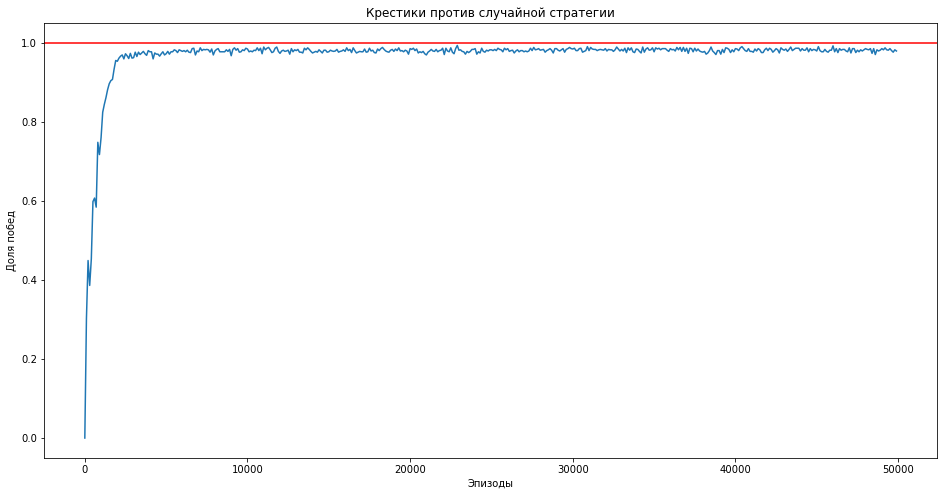

In [151]:
plt.figure(figsize=(16, 8))
plt.xlabel("Эпизоды")
plt.ylabel("Доля побед")
plt.title("Крестики против случайной стратегии")
plt.axhline(1, c='r')
plt.plot(steps, crosses)

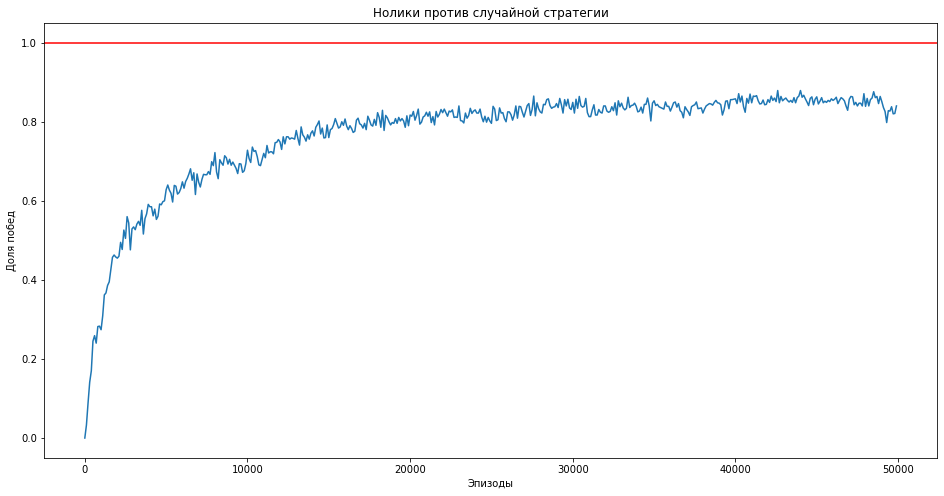

In [152]:
plt.figure(figsize=(16, 8))
plt.xlabel("Эпизоды")
plt.ylabel("Доля побед")
plt.title("Нолики против случайной стратегии")
plt.axhline(1, c='r')
plt.plot(steps, zeros)

Процент выигрышей для каждого из игроков против случайной стратегии стремится к 100% по мере увеличения числа эпизодов обучения. При этом статегия крестиков сходится намного быстрее (уже при 5000 эпизодов).

### Табличное Q-обучение для стратегии крестиков и ноликов для доски 4х4.

In [5]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
env.reset()
size = len(env.getEmptySpaces())
Q = defaultdict(lambda: np.zeros(size))

In [6]:
Q, steps, crosses, zeros = q_learning(env, Q, n_steps=500000, alpha=0.01, eps=0.75, eval_steps=1000)

100%|██████████| 500000/500000 [58:08<00:00, 143.34it/s]   


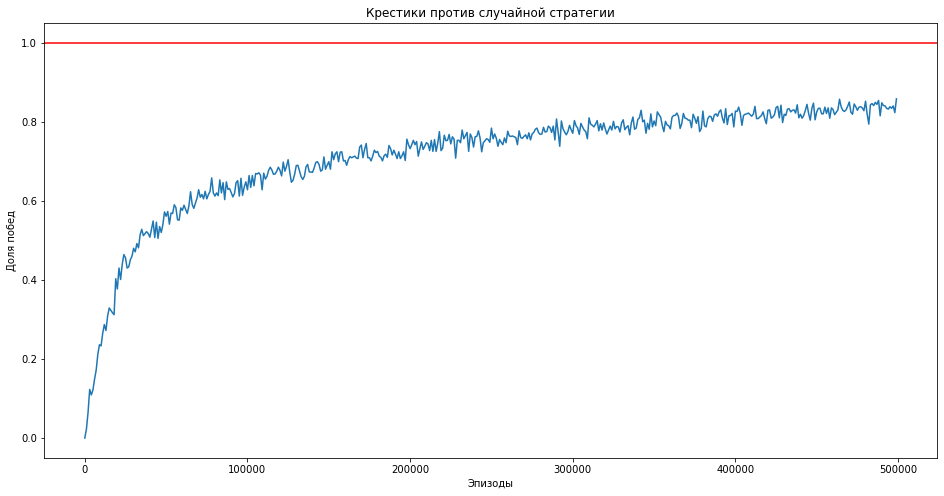

In [7]:
plt.figure(figsize=(16, 8))
plt.xlabel("Эпизоды")
plt.ylabel("Доля побед")
plt.title("Крестики против случайной стратегии")
plt.axhline(1, c='r')
plt.plot(steps, crosses)

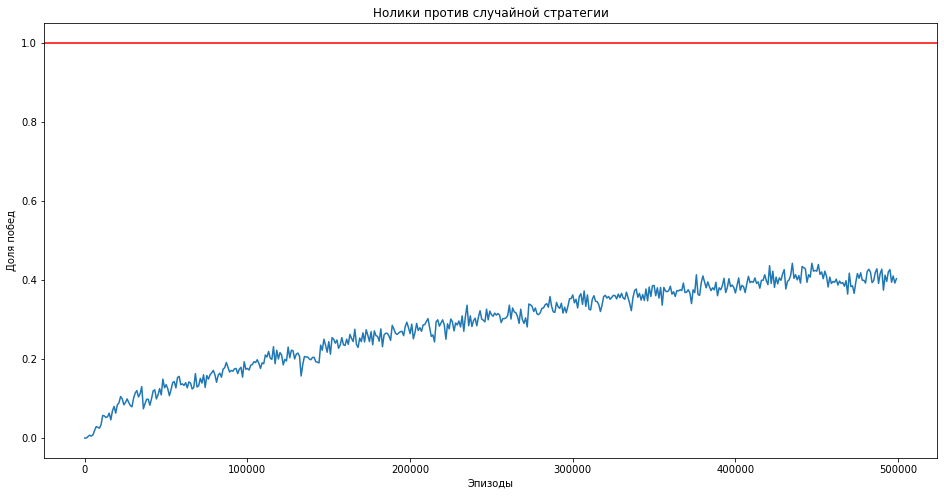

In [8]:
plt.figure(figsize=(16, 8))
plt.xlabel("Эпизоды")
plt.ylabel("Доля побед")
plt.title("Нолики против случайной стратегии")
plt.axhline(1, c='r')
plt.plot(steps, zeros)

В связи с большими вычислительными и временными затратами обучить стратегию до сходимости не получилось. Однако по прошествии 500000 эпизодов обучения на графиках виден ярко выраженный тренд улучшения качества стратегий, как для крестиков против случайной стратегии, так и для ноликов против случайной стратегии.

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

**Задание:**
1. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
1. Реализуйте Double DQN и/или Dueling DQN.


### DQN для стратегии крестиков и ноликов с experience replay для доски 3х3.

In [3]:
from DQN import DQN

In [4]:
# Класс игрока для запоминания состояния и действия

class Player:
    
    def __init__(self, state=None, board=None):
        self.state = state
        self.board = board
        self.action = None
    
    def update_params(self, state, board, action):
        self.state = state
        self.board = board
        self.action = action

In [5]:
def state_to_input(state):
    """Конвертируем хеш состояния поля в np.array."""
    return np.array(list(map(int, state)))


def learning_episode(env, models, eps=0.1, steps_per_update=4, steps_per_target_update=400):
    """Симуляция одного эпизода обучения."""
    env.reset()
    state, empty_spaces, turn = env.getState()
    board = env.board
    players = (Player(state, board), Player(state, board))
    index = 0
    finish = False
    
    while not finish:
        player = players[index]
        model = models[index]
        action = model.make_action(state_to_input(state), eps)
        (state, empty_spaces, turn), reward, finish, _ = env.step(env.action_from_int(action))
        board = env.board
        if not finish:
            transition = (state_to_input(player.state), action, 
                          state_to_input(state), reward, finish)
            model.update(transition, steps_per_update, steps_per_target_update)
        player.update_params(state, board, action)
        index = 1 - index
        
    tr1 = (state_to_input(players[0].state), players[0].action, 
           state_to_input(state), reward, finish)
    models[0].update(tr1, steps_per_update, steps_per_target_update)
    
    tr2 = (state_to_input(players[1].state), players[1].action, 
           state_to_input(state), -reward, finish)
    models[1].update(tr2, steps_per_update, steps_per_target_update)
        
    return models
    

def get_episode(env, model, crosses_is_random=False, zeros_is_random=True):
    """Симуляция эпизода для подсчета процента выигрышей выбранного игрока."""
    env.reset()
    state, empty_spaces, turn = env.getState() 
    board = env.board
    finish = False
    
    while not finish:
        if turn == 1 and crosses_is_random:
            action = np.random.choice(model.get_empty_cells_indices(state_to_input(state)))
        if turn == 1 and not crosses_is_random:
            action = model.act(state_to_input(state))
        if turn == -1 and zeros_is_random:
            action = np.random.choice(model.get_empty_cells_indices(state_to_input(state)))
        if turn == -1 and not zeros_is_random:
            action = model.act(state_to_input(state))
        
        (state, empty_spaces, turn), reward, finish, _ = env.step(env.action_from_int(action))
    
    if (zeros_is_random and reward == 1) or (crosses_is_random and reward == -1):
        return 1
    return 0
        

def evaluate_policy(env, model, n_steps=1000, crosses_is_random=False, zeros_is_random=True):
    """Оценка качества обученной стратегии."""
    rewards = []
    
    for _ in range(n_steps):
        reward = get_episode(env, model, crosses_is_random, zeros_is_random)
        rewards.append(reward)
        
    return np.mean(rewards)


def learning_cycle(env, models, n_steps=100000, initial_steps=2048, eps=0.1, verbose=True, 
                   eval_steps=50, steps_per_update=4, steps_per_target_update=400):
    """Цикл DQN обучения."""
    crosses = []
    zeros = []
    steps = []
    env.reset()
    state, empty_spaces, turn = env.getState()
    board = env.board
    
#     Инициализируем experience replay буффер
    for _ in range(initial_steps):
        action = np.random.choice(models[0].get_empty_cells_indices(state_to_input(state)))

        (next_state, empty_spaces, turn), reward, done, _ = env.step(env.action_from_int(action))
        next_board = env.board
        models[0].buffer.store((state_to_input(state), action, state_to_input(next_state), reward, done))
        models[1].buffer.store((state_to_input(state), action, state_to_input(next_state), reward, done))
        
        if not done:
            state = next_state 
            board = next_board
        else:
            env.reset()
            state, empty_spaces, turn = env.getState()
            board = env.board
    
    for i in tqdm(range(n_steps), disable=not verbose):
        models = learning_episode(env, models, eps, steps_per_update, steps_per_target_update)
        
        if i % eval_steps == 0:
            steps.append(i)
            cross = evaluate_policy(env, models[0], crosses_is_random=False, zeros_is_random=True)
            zero = evaluate_policy(env, models[1], crosses_is_random=True, zeros_is_random=False)
            crosses.append(cross)
            zeros.append(zero)
            
    return models, steps, crosses, zeros

In [6]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()
size = len(env.getEmptySpaces())
first_model = DQN(size, size)
second_model = DQN(size, size)
models = (first_model, second_model)

In [7]:
models, steps, crosses, zeros = learning_cycle(env, models, n_steps=50000, eps=0.75, eval_steps=100)

100%|██████████| 50000/50000 [25:36<00:00, 32.53it/s]  


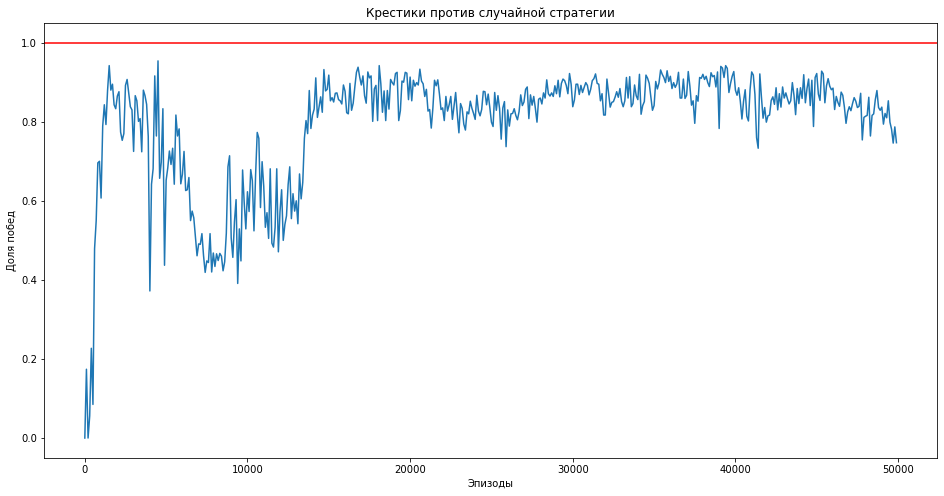

In [4]:
plt.figure(figsize=(16, 8))
plt.xlabel("Эпизоды")
plt.ylabel("Доля побед")
plt.title("Крестики против случайной стратегии")
plt.axhline(1, c='r')
plt.plot(steps, crosses)

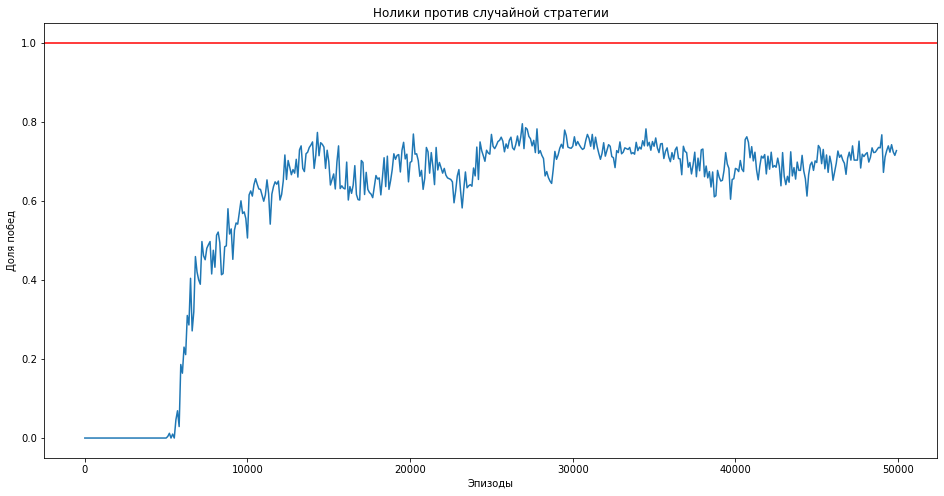

In [5]:
plt.figure(figsize=(16, 8))
plt.xlabel("Эпизоды")
plt.ylabel("Доля побед")
plt.title("Нолики против случайной стратегии")
plt.axhline(1, c='r')
plt.plot(steps, zeros)

Обучить нейросеть до явной сходимости стратегий не получилось в связи с временными затратами. Тем не менее, для крестиков против случайной стратегии и ноликов против случайной стратегии наблюдаются улучшения стратегий по ходу обучения DQN.

### DQN для стратегии крестиков и ноликов с experience replay для доски 4х4.

In [6]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
env.reset()
size = len(env.getEmptySpaces())
first_model = DQN(size, size)
second_model = DQN(size, size)
models = (first_model, second_model)

In [7]:
models, steps, crosses, zeros = learning_cycle(env, models, n_steps=50000, eps=0.75, eval_steps=100)

100%|██████████| 50000/50000 [49:10<00:00, 16.95it/s]  


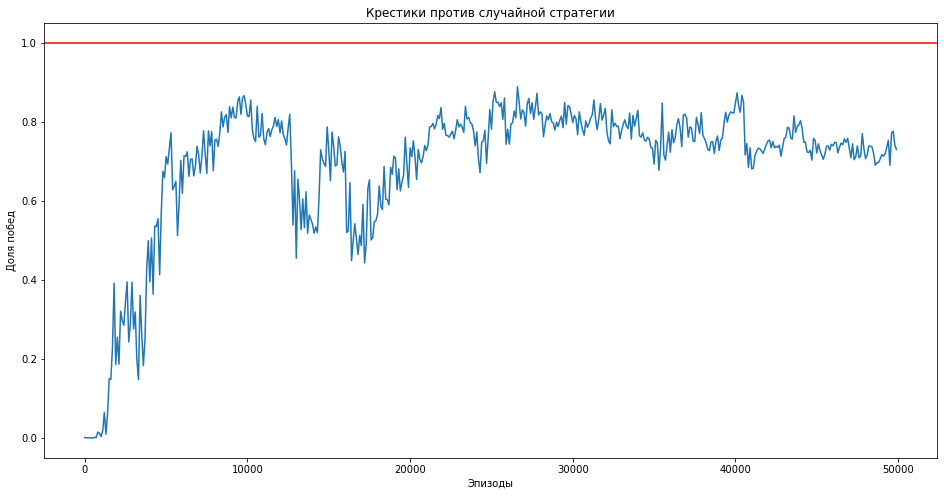

In [4]:
plt.figure(figsize=(16, 8))
plt.xlabel("Эпизоды")
plt.ylabel("Доля побед")
plt.title("Крестики против случайной стратегии")
plt.axhline(1, c='r')
plt.plot(steps, crosses)

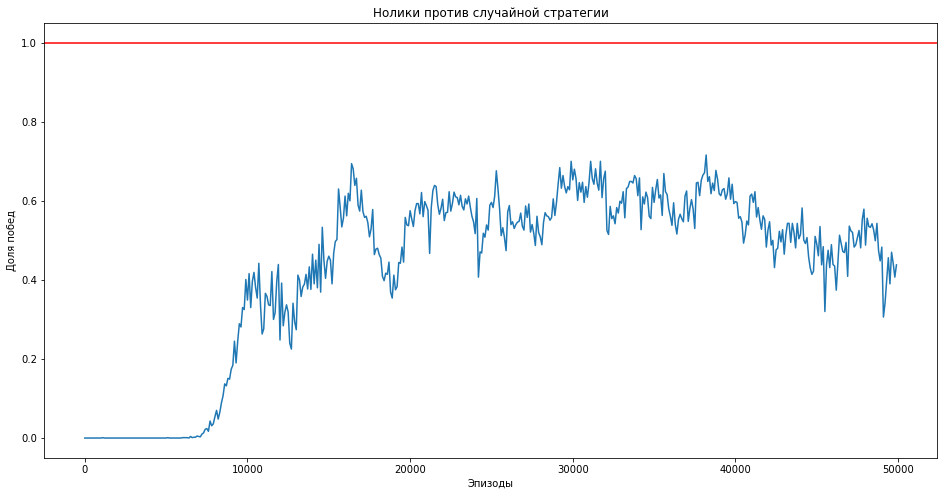

In [5]:
plt.figure(figsize=(16, 8))
plt.xlabel("Эпизоды")
plt.ylabel("Доля побед")
plt.title("Нолики против случайной стратегии")
plt.axhline(1, c='r')
plt.plot(steps, zeros)

Для поля 4х4 статегия, обученная с помощью DQN, со временем улучшается, как для крестиков, так и для ноликов. Однако, в связи с увеличением размеров пространств состояний и действий, обучение стратегии до сходимости занимает очень много времени.  